### 모델링
선형 기반 모델 : SVM, LogisticRegression

1. 데이터 불러오기
2. 데이터셋 분할
3. 오버샘플링
4. 스케일링
5. 모델링
6. 성능검증

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

# 경고창 제거
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
%config InlineBackend.figure_format = 'retina'

In [5]:
train_df = pd.read_csv('train_data.csv', index_col=0)
test_df = pd.read_csv('test_수축기.csv', index_col=0)

label
0.0    1530
1.0      36
Name: count, dtype: int64
label
0.0    97.701149
1.0     2.298851
Name: proportion, dtype: float64


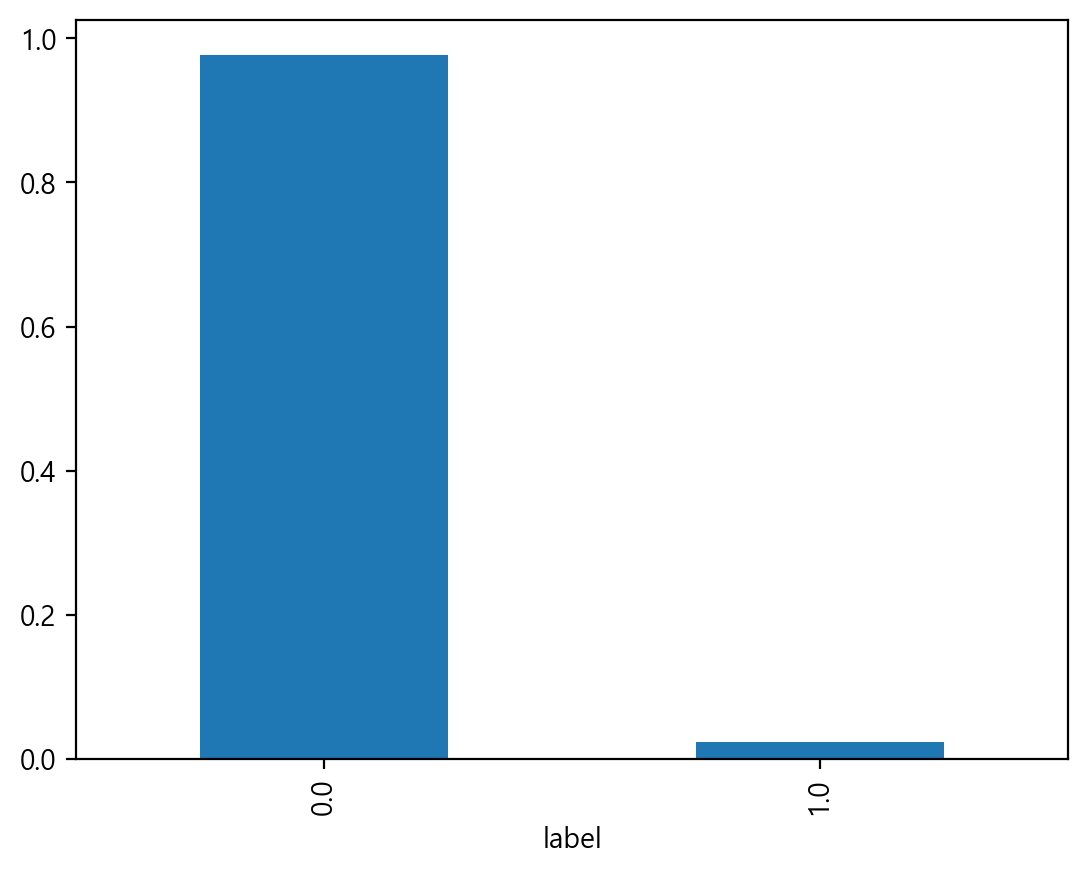

In [7]:
# 데이터 불균형 확인
import pandas as pd 
print(train_df['label'].value_counts())
train_df['label'].value_counts(normalize=True).plot(kind='bar')
print(train_df['label'].value_counts(normalize=True)*100)

In [8]:
# train/test셋 분리
X_train = train_df.drop(columns='label',axis=1)
y_train = train_df[['label']]
X_val = test_df.drop(columns='label',axis=1)
y_val = test_df[['label']]

In [11]:
X_train = X_train[['자기자본순이익률_산업평균_차이','매출액순이익률_상위10개_변동성','순이익증가율_비율','순이익증가율_산업평균_변동성']]
X_val = X_val[['자기자본순이익률_산업평균_차이','매출액순이익률_상위10개_변동성','순이익증가율_비율','순이익증가율_산업평균_변동성']]

In [12]:
# 표준화
features_to_standardize = ['자기자본순이익률_산업평균_차이','매출액순이익률_상위10개_변동성','순이익증가율_비율','순이익증가율_산업평균_변동성']
scaler_standardize = StandardScaler()
X_train = scaler_standardize.fit_transform(X_train[features_to_standardize])
X_val = scaler_standardize.transform(X_val[features_to_standardize])

X_train = pd.DataFrame(X_train, columns=features_to_standardize)
X_val = pd.DataFrame(X_val, columns=features_to_standardize)

In [13]:
from sklearn.base import clone
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# SMOTE를 사용하여 데이터 오버샘플링
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train.values.ravel())  # y_train을 1D array로 변환

# 모델별 하이퍼파라미터 그리드 설정
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1, 'scale']
}

param_grid_logreg = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# 모델 목록
models = {
    'SVC': [SVC(), param_grid_svc],
    'Logistic Regression': [LogisticRegression(), param_grid_logreg]
}

# 결과를 저장할 리스트 초기화
results = []

# 각 모델에 대해 GridSearchCV 실행 및 평가
for name, (model, params) in models.items():
    clf = GridSearchCV(model, params, scoring='accuracy', cv=5)
    clf.fit(X_train_res, y_train_res)
    
    # 최적의 하이퍼파라미터 출력
    print(f"Best parameters for {name}: {clf.best_params_}")
    
    # 최적의 하이퍼파라미터로 모델 생성
    best_model = clone(model).set_params(**clf.best_params_)
    best_model.fit(X_train_res, y_train_res)
    
    # 검증 데이터셋에 대한 예측
    predictions = best_model.predict(X_val)
    
    # 성능 지표 계산
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions, average='binary')
    recall = recall_score(y_val, predictions, average='binary')
    f1 = f1_score(y_val, predictions, average='binary')
    
    # 결과 저장
    results.append([name, accuracy, precision, recall, f1])
    
    # train 데이터셋에 대한 예측 결과를 저장
    train_df[name + '_pred'] = best_model.predict(X_train)

# 결과 DataFrame 생성 및 출력
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
print(results_df)

Best parameters for SVC: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
                 Model  Accuracy  Precision  Recall  F1 Score
0                  SVC  0.530741   0.014313    0.75  0.028090
1  Logistic Regression  0.328662   0.011341    0.85  0.022383


0.0    1530
1.0    1530
Name: count, dtype: int64
0.0    50.0
1.0    50.0
Name: proportion, dtype: float64


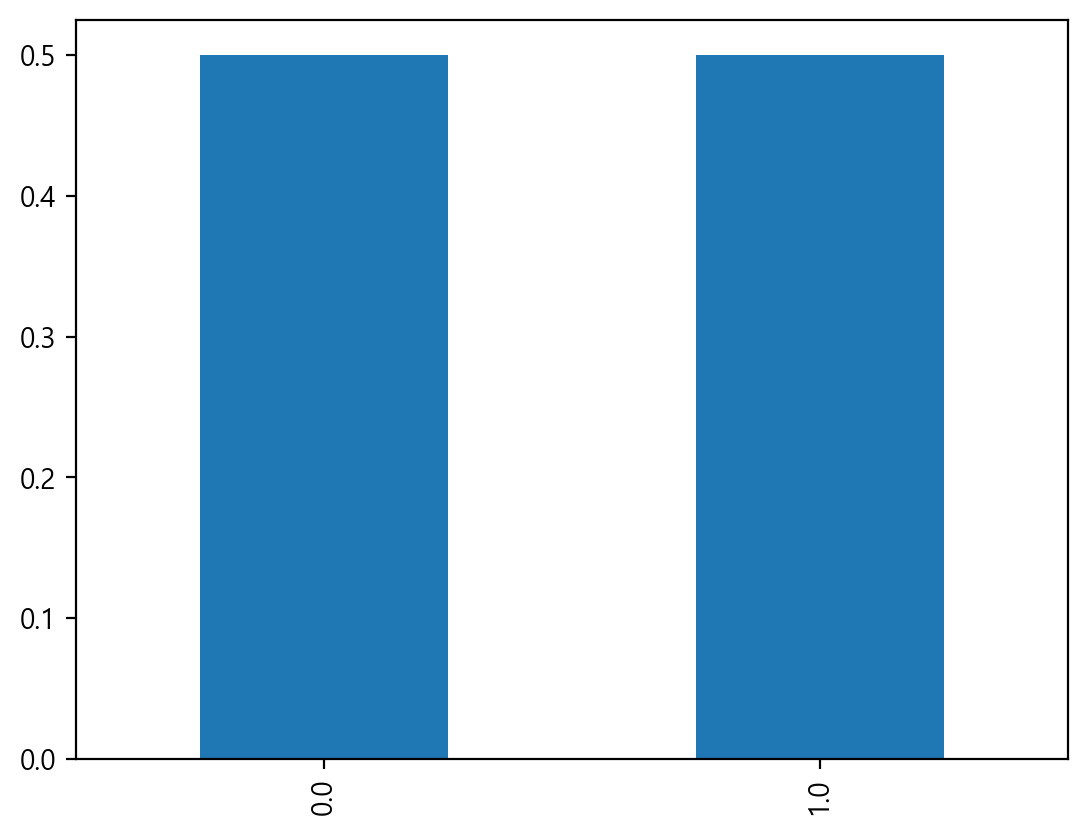

In [14]:
import pandas as pd

# y_train_res를 판다스 Series 객체로 변환
y_train_res_series = pd.Series(y_train_res)

# value_counts() 메소드로 각 클래스의 개수를 출력
print(y_train_res_series.value_counts())

# 데이터 불균형 확인
y_train_res_series.value_counts(normalize=True).plot(kind='bar')
print(y_train_res_series.value_counts(normalize=True)*100)